In [1]:
import cv2
import numpy as np
from sklearn.svm import SVR
from sklearn.metrics import r2_score
import pandas as pd
import time
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.ensemble import RandomForestRegressor
from google.colab import files


In [2]:
conc = []
filenames = []
light = [110,150,200,250,300,350,400,450,540,600,650,700,750,800,850,900,950,1000,1050]    
light_norm = {'110': -1.592,'150':-1.457,'200':-1.287,'250':-1.117,'300':-0.947,'350':-0.777,'400':-0.608,
              '450': -0.438,'540':-0.132,'600':0.071,'650':0.241,'700':0.411,'750': 0.581,'800': 0.751,
              '850':0.920,'900':1.090,'950':1.260,'1000':1.430,'1050':1.600}

for i in range(1,21):
    conc.append("C"+str(i))
for i in conc:
    for j in light:        
        filenames.append(i + '_' + str(j)+'.jpg')  
for j in ['C1_1050.jpg','C2_1050.jpg','C2_300.jpg','C3_1050.jpg']:
    filenames.remove(j)

dcw = {'C1':'0.062','C2':'0.140','C3':'0.228','C4':'0.337','C5':'0.466','C6':'0.620','C7':'0.871','C8':'0.999',
       'C9':'1.177','C10':'1.254','C11':'1.396','C12':'1.482','C13':'1.553','C14':'2.007','C15':'2.320',
       'C16':'2.814','C17':'3.199','C18':'3.694','C19':'4.577','C20':'5.519'}
dcw_norm = {'C1':'-1.124','C2':'-1.071','C3':'-1.012','C4':'-0.939','C5':'-0.853','C6':'-0.749','C7':'-0.580','C8':'-0.495',
       'C9':'-0.375','C10':'-0.323','C11':'-0.228','C12':'-0.170','C13':'-0.123','C14':'0.182','C15':'0.392',
       'C16':'0.724','C17':'0.982','C18':'1.314','C19':'1.907','C20':'2.539'}

In [15]:
# All_functions
def extract_data_from_imgs(imgs):  #extract GSVs from images
    Data = {}
    for img in imgs:
        gray_img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
        Data[img] = gray_img
    return Data
def selecting_mid_col(Data):
    df = pd.DataFrame()
    for key, val in Data.items():
        df[key.split('.')[0]] = val[:,5]
    return df

def selecting_mid_col_norm(Data):  
    df = pd.DataFrame()
    for key, val in Data.items():
        df[key.split('.')[0]] = (val[:,5]-44.79)/66.51
    return df

def get_data_at_row_col(df, row):   #extract GSVs at each pixels 
    label_row_train = []
    X_row_conc_train = []
    X_row_light_train = []
    X_train = []
    
    label_row_test = []
    X_row_conc_test = []
    X_row_light_test = []
    X_test = []
    
    df_train = df1[df1['is_train'] == True]
    df_test = df1[df1['is_train'] == False]
    
    for key in list(df_train.index):
        X_row_conc_train.append(float(dcw_norm[key.split('_')[0]]))
        X_row_light_train.append(float(light_norm[key.split('_')[1].split('.')[0]]))
        label_row_train.append(df_train[row][key])
    X_train.append(X_row_conc_train)
    X_train.append(X_row_light_train)
    X_train = np.array(X_train)
    X_train = X_train.T
    
    for key in list(df_test.index):
        X_row_conc_test.append(float(dcw_norm[key.split('_')[0]]))
        X_row_light_test.append(float(light_norm[key.split('_')[1].split('.')[0]]))
        label_row_test.append(df_test[row][key])
    X_test.append(X_row_conc_test)
    X_test.append(X_row_light_test)
    X_test = np.array(X_test)
    X_test = X_test.T
    
    return X_train, label_row_train, X_test, label_row_test



def output_organize(parameters):
    pos = []
    c = []
    gamma = []
    rs = []
    for key, val in parameter.items():
        pos.append(key)
        c.append(val[0])
        gamma.append(val[1])
        rs.append(val[2])
    
    df = pd.DataFrame()
    df['pos'] = pos
    df['C'] = c
    df['Gamma'] = gamma
    df['R-squared'] = rs
    return df

#prediction 
def prediction(X, y, c, g, X_test):
    svr_rbf = SVR(kernel='rbf', C=c, gamma=g)
    svr_rbf.fit(np.array(X) , y)
    yhat = svr_rbf.predict(np.array(X_test))
    return yhat

def load_data(LDP_traing,GRM_training):
  df1 = pd.read_csv(LDP_traing,index_col=0)
  df4 = pd.read_csv(GRM_training)
  return df1, df4

def light_normalization(light):
  light_norm = np.array(light)*0.0034-1.966
  return light_norm

def dcw_normalization(dcw_):
  dcw_norm_ = (np.array(dcw_)-1.73574)/1.49035
  return dcw_norm_

def dcw_denormalization(dcw_norm_):
  dcw_ = np.array(dcw_norm_)*1.49035+1.73574
  return dcw_

def prediction_RF(X,y,X_test):
  RF_LDPM = RandomForestRegressor()
  RF_LDPM.fit(X, y)
  yhat = RF_LDPM.predict(np.array(X_test))
  return yhat

def simulation_LDP_RF(df1,new_conc_light):
  pred_LDP = []
  for i in range(208):
    X_train,y_train, X_test, y_test = get_data_at_row_col(df1, str(i))
    yhat = prediction_RF(X_train, y_train, np.array(new_conc_light))
    pred_LDP.append(list(yhat))
  return np.array(list(pred_LDP)).T

def simulation_growth(df4,pred_LDP):
  features_num = list(range(208))
  #features_num = list(range(20))
  features = []
  for i in features_num:
    features.append(str(i))

  label = ['Growth rate']

  train = df4[df4['is_train'] == True ]
  test = df4[df4['is_train'] == False ]
  X_train = train[features].to_numpy()
  X_test = test[features].to_numpy()
  y_train = train[label].to_numpy()[:,0]
  y_test = test[label].to_numpy()[:,0]

  RF = RandomForestRegressor()
  RF.fit(X_train, y_train)
  pred_growth_rate = RF.predict(pred_LDP)

  return pred_growth_rate

def simulation_update(new_conc_light,pred_growth_rate,new_light,interval):
  updated_conc_light = []

  for i in range(len(new_conc_light)):
    feature_temp = []
    #print('dcw_denormalization(new_conc_light[i][0])',dcw_denormalization(new_conc_light[i][0]))
    feature_temp.append(dcw_normalization(dcw_denormalization(new_conc_light[i][0]) + pred_growth_rate[i]*interval))
    feature_temp.append(new_light)
    #print(feature_temp)
    updated_conc_light.append(feature_temp)
  return np.array(updated_conc_light)

def run_simualtion_RF(LDP_traing,GRM_training,interval,initial_conc,light_program):
  record = []
  light_norm = light_normalization(light_program)
  new_conc_light = []
  

  for i in initial_conc:
    #print(i)
    feature_temp = []
    feature_temp.append(dcw_normalization(i))
    feature_temp.append(light_norm[0])
    new_conc_light.append(feature_temp)
  new_conc_light = np.array(new_conc_light)
  #print(new_conc_light)
  record.append(new_conc_light)

  df1, df4 = load_data(LDP_traing,GRM_training)


  for i in range(1,len(light_norm)):
    pred_LDP = simulation_LDP_RF(df1,new_conc_light)
    #print('pred_LDP')
    pred_growth_rate = simulation_growth(df4,pred_LDP)
    #print('pred_growth_rate')
    new_conc_light = simulation_update(new_conc_light,pred_growth_rate,light_norm[i],interval)
    #print('*',new_conc_light)
    record.append(new_conc_light)
    if i%10 ==0:
      print('Simulation in progress ...', i/len(light_norm)*100, ' % Finished')
  return record




#LDPM_pond

###Load training data

In [4]:
uploaded = files.upload()
df1 = pd.read_csv('all_train_data_norm.csv', index_col=0)
df1.head()

Saving all_train_data_norm.csv to all_train_data_norm.csv


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,is_train
C1_110,2.047963,2.168245,2.243422,2.243422,2.168245,2.138175,2.032927,1.837468,1.702150,1.476620,1.281161,1.175913,0.965419,0.890242,0.784995,0.694783,0.619606,0.574500,0.574500,0.484288,0.394076,0.379041,0.348970,0.333935,0.303864,0.288829,0.318899,0.273793,0.288829,0.243723,0.213652,0.273793,0.318899,0.228687,0.168546,0.183581,0.228687,0.198617,0.213652,0.168546,...,0.243723,0.243723,0.258758,0.258758,0.198617,0.243723,0.333935,0.333935,0.303864,0.273793,0.288829,0.303864,0.303864,0.318899,0.333935,0.333935,0.288829,0.348970,0.333935,0.333935,0.379041,0.394076,0.379041,0.394076,0.409111,0.439182,0.409111,0.484288,0.544429,0.529394,0.544429,0.604571,0.619606,0.604571,0.649677,0.739889,0.830101,0.950383,1.040595,True
C1_150,2.544129,2.619305,2.664411,2.664411,2.634341,2.619305,2.544129,2.468952,2.423846,2.318599,2.138175,2.002857,1.852503,1.732221,1.611938,1.491655,1.296196,1.205984,1.085701,1.010525,0.935348,0.890242,0.830101,0.800030,0.784995,0.709818,0.679747,0.694783,0.739889,0.694783,0.664712,0.634641,0.664712,0.634641,0.649677,0.604571,0.649677,0.649677,0.559465,0.559465,...,0.694783,0.724853,0.754924,0.739889,0.754924,0.724853,0.724853,0.739889,0.784995,0.784995,0.769959,0.769959,0.769959,0.769959,0.784995,0.845136,0.800030,0.830101,0.845136,0.830101,0.875207,0.920313,0.920313,0.905277,0.950383,1.040595,1.085701,1.130807,1.130807,1.100737,1.100737,1.221019,1.266125,1.296196,1.401443,1.446549,1.536761,1.717185,1.792362,True
C1_200,2.814765,2.829800,2.814765,2.829800,2.829800,2.799729,2.754623,2.724553,2.679447,2.619305,2.514058,2.438881,2.378740,2.258457,2.168245,2.062998,1.927680,1.837468,1.807397,1.672079,1.566832,1.476620,1.356337,1.326267,1.311231,1.205984,1.130807,1.145843,1.115772,1.160878,1.160878,1.115772,1.085701,1.070666,1.055631,1.055631,1.040595,1.055631,1.040595,1.040595,...,1.221019,1.281161,1.311231,1.296196,1.296196,1.311231,1.311231,1.296196,1.311231,1.296196,1.266125,1.296196,1.266125,1.266125,1.311231,1.371373,1.356337,1.356337,1.416479,1.446549,1.401443,1.416479,1.521726,1.506691,1.491655,1.566832,1.581867,1.672079,1.657044,1.642009,1.732221,1.822433,1.852503,1.882574,1.927680,2.047963,2.123139,2.168245,2.243422,True
C1_250,2.784694,2.814765,2.844835,2.859871,2.844835,2.814765,2.799729,2.784694,2.739588,2.709517,2.649376,2.574199,2.514058,2.468952,2.393775,2.318599,2.288528,2.153210,2.078033,2.047963,1.972786,1.897609,1.822433,1.822433,1.747256,1.687115,1.672079,1.657044,1.626973,1.581867,1.581867,1.581867,1.551797,1.521726,1.506691,1.521726,1.551797,1.506691,1.536761,1.536761,...,1.957751,1.942715,2.017892,1.987821,1.987821,1.972786,1.987821,2.017892,2.017892,2.032927,1.987821,1.972786,1.957751,1.972786,2.032927,2.017892,1.987821,2.047963,2.108104,2.093069,2.108104,2.153210,2.123139,2.138175,2.168245,2.213351,2.198316,2.228387,2.273493,2.288528,2.303563,2.333634,2.363705,2.393775,2.438881,2.514058,2.559164,2.574199,2.634341,True
C1_300,2.453917,2.664411,2.679447,2.709517,2.709517,2.694482,2.664411,2.604270,2.529093,2.483987,2.408811,2.363705,2.333634,2.303563,2.198316,2.138175,2.138175,2.093069,2.017892,2.002857,1.987821,1.957751,1.942715,1.927680,1.897609,1.852503,1.852503,1.837468,1.852503,1.822433,1.807397,1.837468,1.807397,1.822433,1.837468,1.807397,1.792362,1.777327,1.822433,1.717185,...,1.972786,1.957751,1.942715,1.942715,2.002857,2.017892,2.017892,2.002857,2.002857,2.047963,2.062998,2.047963,2.032927,2.002857,2.062998,2.047963,2.047963,2.047963,2.047963,2.062998,2.017892,2.047963,2.047963,2.062998,2.062998,2.093069,2.123139,2.093069,2.078033,2.138175,2.138175,2.138175,2.183281,2.198316,2.213351,2.273493,2.273493,2.258457,2.333634,True


###Training 

In [5]:
all_rs = []
all_pred = []
all_y = []
for i in range(208):
  X_train,y_train, X_test, y_test = get_data_at_row_col(df1, str(i))
  RF_LDPM = RandomForestRegressor()
  RF_LDPM.fit(X_train, y_train)
  y_pred = RF_LDPM.predict(X_test)
  rs = r2_score(y_test,y_pred)
  all_rs.append(rs)
  all_pred.append(y_pred)
  all_y.append(y_test)
print(np.min(all_rs))  #expected output: ~0.94

0.9398247489175346


#GRM_pond

###Load training data 

In [6]:
uploaded = files.upload()
df4 = pd.read_csv('all_pred_for_GRM_RF.csv')
df4.head()

Saving all_pred_for_GRM_RF.csv to all_pred_for_GRM_RF.csv


,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,Growth rate,is_train
0,0,2.523530,2.688167,2.737483,2.763194,2.777176,2.798226,2.807548,2.809653,2.816118,2.814614,2.804390,2.809953,2.802736,2.781537,2.780484,2.767854,2.759435,2.789205,2.774470,2.742595,2.726207,2.735077,2.697188,2.671929,2.649977,2.629980,2.553451,2.526537,2.497820,2.456322,2.438731,2.394226,2.314088,2.260111,2.217261,2.192001,2.059390,2.010825,1.980604,...,-0.026763,0.024508,0.031273,0.001804,0.021801,0.038942,0.072921,0.082995,0.138475,0.198917,0.184032,0.251842,0.330326,0.338445,0.464742,0.436325,0.464742,0.556458,0.517065,0.532852,0.589836,0.611788,0.677793,0.681401,0.809051,0.880469,0.895204,0.912494,0.964216,0.979702,1.021952,1.038490,1.007818,0.942866,0.894302,0.912194,0.920764,0.944670,0.004410,True
1,1,2.523530,2.688167,2.737483,2.763194,2.777176,2.798226,2.807548,2.809653,2.816118,2.814614,2.804390,2.809953,2.802736,2.781537,2.780484,2.767854,2.759435,2.789205,2.774470,2.742595,2.726207,2.735077,2.697188,2.671929,2.649977,2.629980,2.553451,2.526537,2.497820,2.456322,2.438731,2.394226,2.314088,2.260111,2.217261,2.192001,2.059390,2.010825,1.980604,...,-0.026763,0.024508,0.031273,0.001804,0.021801,0.038942,0.072921,0.082995,0.138475,0.198917,0.184032,0.251842,0.330326,0.338445,0.464742,0.436325,0.464742,0.556458,0.517065,0.532852,0.589836,0.611788,0.677793,0.681401,0.809051,0.880469,0.895204,0.912494,0.964216,0.979702,1.021952,1.038490,1.007818,0.942866,0.894302,0.912194,0.920764,0.944670,0.004410,True
2,2,2.547737,2.628928,2.679747,2.705608,2.727109,2.762742,2.790708,2.789806,2.781236,2.794768,2.801985,2.812810,2.800631,2.789656,2.780785,2.776876,2.772515,2.777026,2.750564,2.739738,2.722899,2.717486,2.690723,2.655089,2.609532,2.576755,2.511352,2.498271,2.440084,2.383100,2.373177,2.300707,2.192001,2.148399,2.093369,2.061043,1.949331,1.847091,1.825139,...,-0.099985,-0.081642,-0.056683,-0.081642,-0.059540,-0.042400,-0.060292,0.001804,0.017441,0.031123,0.008420,0.071869,0.103593,0.150804,0.250338,0.207187,0.280108,0.282514,0.256954,0.308375,0.317396,0.270035,0.379341,0.318749,0.448203,0.548038,0.508946,0.510750,0.569989,0.637498,0.715231,0.796121,0.854909,0.874906,0.914299,0.932491,0.974891,0.963765,0.004414,True
3,3,2.547737,2.628928,2.679747,2.705608,2.727109,2.762742,2.790708,2.789806,2.781236,2.794768,2.801985,2.812810,2.800631,2.789656,2.780785,2.776876,2.772515,2.777026,2.750564,2.739738,2.722899,2.717486,2.690723,2.655089,2.609532,2.576755,2.511352,2.498271,2.440084,2.383100,2.373177,2.300707,2.192001,2.148399,2.093369,2.061043,1.949331,1.847091,1.825139,...,-0.099985,-0.081642,-0.056683,-0.081642,-0.059540,-0.042400,-0.060292,0.001804,0.017441,0.031123,0.008420,0.071869,0.103593,0.150804,0.250338,0.207187,0.280108,0.282514,0.256954,0.308375,0.317396,0.270035,0.379341,0.318749,0.448203,0.548038,0.508946,0.510750,0.569989,0.637498,0.715231,0.796121,0.854909,0.874906,0.914299,0.932491,0.974891,0.963765,0.004418,False
4,4,2.547737,2.628928,2.679747,2.705608,2.727109,2.762742,2.790708,2.789806,2.781236,2.794768,2.801985,2.812810,2.800631,2.789656,2.780785,2.776876,2.772515,2.777026,2.750564,2.739738,2.722899,2.717486,2.690723,2.655089,2.609532,2.576755,2.511352,2.498271,2.440084,2.383100,2.373177,2.300707,2.192001,2.148399,2.093369,2.061043,1.949331,1.847091,1.825139,...,-0.099985,-0.081642,-0.056683,-0.081642,-0.059540,-0.042400,-0.060292,0.001804,0.017441,0.031123,0.008420,0.071869,0.103593,0.150804,0.250338,0.207187,0.280108,0.282514,0.256954,0.308375,0.317396,0.270035,0.379341,0.318749,0.448203,0.548038,0.508946,0.510750,0.569989,0.637498,0.715231,0.796121,0.854909,0.874906,0.914299,0.932491,0.974891,0.963765,0.004422,True


###Data processing

In [7]:
features_num = list(range(208))
features = []
for i in features_num:
  features.append(str(i))

label = ['Growth rate']

train = df4[df4['is_train'] == True ]
test = df4[df4['is_train'] == False ]
X_train = train[features].to_numpy()
X_test = test[features].to_numpy()
y_train = train[label].to_numpy()[:,0]
y_test = test[label].to_numpy()[:,0]

###Training

In [8]:
RF = RandomForestRegressor()
RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)
rs = r2_score(y_test,y_pred)
print(rs)  #expected output: ~0.98

0.9803534493185948


###Ploting

Text(0, 0.5, 'Predicted Growth Rate')

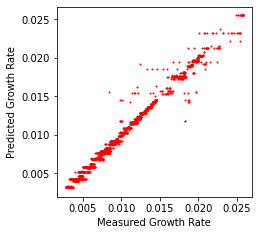

In [9]:
figure =  plt.figure(figsize=(3.5,3.5))
plt.plot(np.array(y_test), np.array(y_pred), 'ro',markersize=1)
plt.xlabel('Measured Growth Rate')
plt.ylabel('Predicted Growth Rate')

#Growth simulation

###Set initial conditions 

In [11]:
# initialize conditions 0.05h as interveal 
light = np.ones(20)*224
light = np.append(light,np.ones(20)*504)
light = np.append(light,np.ones(20)*728)
light = np.append(light,np.ones(200)*840)
light = np.append(light,np.ones(20)*728)
light = np.append(light,np.ones(20)*504)
light = np.append(light,np.ones(20)*224)

initial_conc = [0.1,0.4,0.6,0.8]


###Run simulation

In [16]:
light_input = light
conc_input = initial_conc
record = run_simualtion_RF('all_train_data_norm.csv','all_pred_for_GRM_RF.csv',0.05, conc_input, light_input )

growth_prediction = []

for i in range(len(light_input)):
  temp = []
  for j in range(len(conc_input)):
    temp.append(record[i][j][0])
  growth_prediction.append(temp)

df5 = pd.DataFrame(dcw_denormalization(np.array(growth_prediction)))

df5.head()




Simulation in progress ... 3.125  % Finished
Simulation in progress ... 6.25  % Finished
Simulation in progress ... 9.375  % Finished
Simulation in progress ... 12.5  % Finished
Simulation in progress ... 15.625  % Finished
Simulation in progress ... 18.75  % Finished
Simulation in progress ... 21.875  % Finished
Simulation in progress ... 25.0  % Finished
Simulation in progress ... 28.125  % Finished
Simulation in progress ... 31.25  % Finished
Simulation in progress ... 34.375  % Finished
Simulation in progress ... 37.5  % Finished
Simulation in progress ... 40.625  % Finished
Simulation in progress ... 43.75  % Finished
Simulation in progress ... 46.875  % Finished
Simulation in progress ... 50.0  % Finished
Simulation in progress ... 53.125  % Finished
Simulation in progress ... 56.25  % Finished
Simulation in progress ... 59.375  % Finished
Simulation in progress ... 62.5  % Finished
Simulation in progress ... 65.625  % Finished
Simulation in progress ... 68.75  % Finished
Simulat

,0,1,2,3
0,0.100000,0.400000,0.600000,0.800000
1,0.100411,0.400470,0.600619,0.800549
2,0.100578,0.401108,0.601261,0.801101
3,0.100747,0.401782,0.601906,0.801655
4,0.100917,0.402487,0.602528,0.802213


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>